### imports

In [1]:
import os
import re
import time
import datetime
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver  
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options

import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

### criteria

In [2]:
#POSTCODE IS COMPULSORY

criteria = {
    "postcode": "UB10 0EQ",
    "radius": "300",
    "year_from": "2005",
    "year_to": "2015",
    "price_from": "3000",
    "price_to": "10000",
}

criteria2 = {
    "postcode": "CV31 3QR", 
    "radius": "200",
    "year_from": "1995",
    "year_to": "2013",
    "price_from": "1000",
    "price_to": "40000",
}

EmptyCriteria = {
    "postcode": "UB10 0EQ",  # Postcode is necessary
}

corsa = [
     {
         "make": "Vauxhall",
         "model": "Corsa"
    },
]

cars = [
     {
         "make": "Vauxhall",
         "model": "Corsa"
    },

     {
         "make": "Toyota",
         "model": "Yaris"
    },

     {
         "make": "Honda",
         "model": "Civic"
    }
]

cars2 = [
    {
         "make": "Mazda",
         "model": "MX-5"
    },

    {
         "make": "BMW",
         "model": "Z4"
    },

    {
         "make": "Toyota",
         "model": "Celica"
    },

    {
         "make": "Toyota",
         "model": "GT86"
    }
]


### functions

In [77]:

def scrape_autotrader(cars, criteria):
    chrome_options = Options()
    chrome_options.add_argument("_tt_enable_cookie=1")
    driver = webdriver.Chrome()
    data = []

    for car in cars:
        
        start = time.time()

        print(f'\n')

        # Example URL: 
        # https://www.autotrader.co.uk/car-search?advertising-location=at_cars&include-delivery-option=on&make=Honda&model=Jazz&postcode=LS12AD&radius=10&sort=relevance&year-from=2011&year-to=2015
        
        params = []

        if car.get('make'):
            params.append(f"make={car['make']}")
        if car.get('model'):
            params.append(f"model={car['model']}")
        if criteria.get('postcode'):    
            params.append(f"postcode={criteria['postcode']}") 
        if criteria.get('radius'):    
            params.append(f"radius={criteria['radius']}")
        
        params.append("sort=relevance")
        if criteria.get('year_from'):
            params.append(f"year-from={criteria['year_from']}")
        if criteria.get('year_to'):
            params.append(f"year-to={criteria['year_to']}")
        if criteria.get('price_from'):
            params.append(f"price-from={criteria['price_from']}")
        if criteria.get('price_to'):
            params.append(f"price-to={criteria['price_to']}")
        
        
        url = "https://www.autotrader.co.uk/car-search?advertising-location=at_cars&include-delivery-option=on" + '&'.join(params)        

        driver.get(url)

        time.sleep(5) 

        source = driver.page_source
        content = BeautifulSoup(source, "html.parser")

        number_of_pages = 0

        try:
            results = content.find("span", attrs={"data-testid": "search-result-count"})
            number_of_articles = results.text.split()[0].replace(",","")
            number_of_pages = int(number_of_articles) // 19 # Approximate, overestimated to maximise results

            if number_of_pages == 0:
                number_of_pages = 1

            if number_of_pages > 100: #Max Number of pages to search
                number_of_pages = 100

        except AttributeError:
            print("No results found or couldn't determine number of pages.")
            continue
        except Exception as e:
            print(f"An error occurred while determining number of pages: {e}")
            continue  
        
        if car.get('make'):
                    print(f'Manufacturer:{car['make']}')
                    if car.get('model'):
                        print(f'Model:{car['model']}')

        print(f"There are {number_of_pages} pages in total for {number_of_articles} cars.")
        
        ETAseconds = int(number_of_articles)*11
        ETAminutes = ETAseconds / 60

        if ETAseconds < 120:
            print(f'Estimated search time: {ETAseconds} seconds.')
        else:
            print(f'Estimated search time: {ETAminutes} minutes.')

        for i in range(int(number_of_pages)):
            driver.get(url + f"&page={str(i + 1)}")
            
            time.sleep(5)
            page_source = driver.page_source
            content = BeautifulSoup(page_source, "html.parser")

            articles = content.findAll("div", attrs={"data-testid": "advertCard"})

            for article in articles:
                details = {
                    "name": None,
                    "price": None,
                    "year": None,
                    "mileage": None,
                    "transmission": None,
                    "fuel": None,
                    "engine": None,
                    "owners": None,
                    "location": None,
                    "distance": None,
                    "link": None
                }

                # Name
                if car.get('make'):
                    details['name'] = car['make'] 
                    if car.get('model'):
                        details['name'] += " " + car['model']
                
                # Price
                price_match = re.search(r"[£]\d+(,\d{3})?", article.text)
                if price_match:
                    details["price"] = price_match.group(0)

                # Link
                link_tag = article.find("a", href=re.compile(r"/car-details/"))
                if link_tag and link_tag.has_attr("href"):
                    details["link"] = link_tag["href"]

                # Location & distance
                try:
                    seller_info = article.find("span", attrs={"data-testid": "search-listing-location"}).text
                    location = seller_info.split("Dealer location")[1]
                    details["location"] = location.split("(")[0].strip()
                    details["distance"] = location.split("(")[1].replace(" mile)", "").replace(" miles)", "").strip()
                except Exception:
                    pass  # location info missing

                # Specs
                specs_list = article.find("ul", attrs={"data-testid": "badges-container"})
                if specs_list:
                    for spec in specs_list.find_all("li"):
                        text = spec.get_text(strip=True)

                        if "reg" in text:
                            details["year"] = text

                        if "miles" in text:
                            details["mileage"] = text

                        if text in ["Manual", "Automatic"]:
                            details["transmission"] = text

                        if "." in text and "L" in text:
                            details["engine"] = text

                        if text in ["Petrol", "Diesel"]:
                            details["fuel"] = text

                        if "owner" in text:
                            details["owners"] = text[0]

                data.append(details)


            print(f"Page {str(i + 1)} scraped. ({len(articles)} articles)")
            time.sleep(5)

        print("\n\n")

    print(f"{len(data)} cars total found.")

    end = time.time()  

    print(f"Execution time: {end - start:.4f} seconds")
    
    return data


In [83]:
def output_data(data, criteria, name='cars'):
    df = pd.DataFrame(data)

    df["price"] = df["price"].str.replace("£", "").str.replace(",", "")
    df["price"] = pd.to_numeric(df["price"], errors="coerce").astype("Int64")

    df["year"] = df["year"].str.replace(r"\s(\(\d\d reg\))", "", regex=True)
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

    df["mileage"] = df["mileage"].str.replace(",", "").str.replace(" miles", "")
    df["mileage"] = pd.to_numeric(df["mileage"], errors="coerce").astype("Int64")

    now = datetime.datetime.now()
    df["miles_pa"] = df["mileage"] / (now.year - df["year"])
    df.fillna({'miles_pa': 0},inplace=True)
    df["miles_pa"] = df["miles_pa"].astype(int)

    df["owners"] = df["owners"].fillna("-1") 
    df["owners"] = df["owners"].astype(int)

    df["distance"] = df["distance"].fillna("-1") 
    df["distance"] = df["distance"].astype(int)

    df["link"] = "https://www.autotrader.co.uk" + df["link"] 

    df = df[[
        "name",
        "link",
        "price",
        "year",
        "mileage",
        "miles_pa",
        "owners",
        "distance",
        "location",
        "engine",
        "transmission",
        "fuel",
    ]]

    if criteria.get('price_to'):
        df = df[df["price"] < int(criteria["price_to"])]

    df = df.sort_values(by="distance", ascending=True)

    df.to_csv(name)

    return df

### workspace

In [79]:
data = scrape_autotrader(cars, EmptyCriteria)



Manufacturer:Vauxhall
Model:Corsa
There are 100 pages in total for 8654 cars.
Estimated search time: 1586.5666666666666 minutes.
Page 1 scraped. (26 articles)
Page 2 scraped. (28 articles)
Page 3 scraped. (28 articles)
Page 4 scraped. (27 articles)
Page 5 scraped. (28 articles)
Page 6 scraped. (28 articles)
Page 7 scraped. (26 articles)
Page 8 scraped. (26 articles)
Page 9 scraped. (26 articles)
Page 10 scraped. (26 articles)
Page 11 scraped. (26 articles)
Page 12 scraped. (26 articles)
Page 13 scraped. (26 articles)
Page 14 scraped. (26 articles)
Page 15 scraped. (26 articles)
Page 16 scraped. (26 articles)
Page 17 scraped. (26 articles)
Page 18 scraped. (26 articles)
Page 19 scraped. (26 articles)
Page 20 scraped. (26 articles)
Page 21 scraped. (26 articles)
Page 22 scraped. (26 articles)
Page 23 scraped. (26 articles)
Page 24 scraped. (26 articles)
Page 25 scraped. (26 articles)
Page 26 scraped. (26 articles)
Page 27 scraped. (26 articles)
Page 28 scraped. (26 articles)
Page 29 sc

In [84]:
df = output_data(data, EmptyCriteria, name='cars Empty Criteria 11-08-25')

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7819 entries, 2704 to 7581
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          7819 non-null   object
 1   link          7795 non-null   object
 2   price         7819 non-null   Int64 
 3   year          7581 non-null   Int64 
 4   mileage       7757 non-null   Int64 
 5   miles_pa      7819 non-null   int32 
 6   owners        7819 non-null   int32 
 7   distance      7819 non-null   int32 
 8   location      7792 non-null   object
 9   engine        0 non-null      object
 10  transmission  0 non-null      object
 11  fuel          0 non-null      object
dtypes: Int64(3), int32(3), object(6)
memory usage: 725.4+ KB


In [87]:
df.describe()

,price,year,mileage,miles_pa,owners,distance
count,7819.0,7581.0,7757.0,7.819000e+03,7819.0,7819.000000
mean,8305.573986,2015.079937,62652.812299,-1.949348e+07,-1.0,71.131475
std,6923.603987,5.250877,36687.631622,2.037191e+08,0.0,64.913598
min,1000.0,2001.0,3.0,-2.147484e+09,-1.0,-1.000000
25%,2800.0,2012.0,34223.0,4.381500e+03,-1.0,21.000000
50%,6350.0,2015.0,59000.0,6.191000e+03,-1.0,49.000000
75%,11547.5,2019.0,87791.0,8.375000e+03,-1.0,105.000000
max,53491.0,2025.0,283000.0,4.735400e+04,-1.0,430.000000


In [89]:
df.head()

,name,link,price,year,mileage,miles_pa,owners,distance,location,engine,transmission,fuel
2704,Toyota Yaris,NaN,2791,<NA>,<NA>,0,-1,-1,None,None,None,None
324,Vauxhall Corsa,https://www.autotrader.co.uk/car-details/20250...,2050,2015,103413,10341,-1,-1,None,None,None,None
39,Vauxhall Corsa,NaN,3203,<NA>,<NA>,0,-1,-1,None,None,None,None
6771,Honda Civic,https://www.autotrader.co.uk/car-details/20250...,15600,2021,40415,10103,-1,-1,None,None,None,None
2676,Toyota Yaris,NaN,3159,<NA>,<NA>,0,-1,-1,None,None,None,None


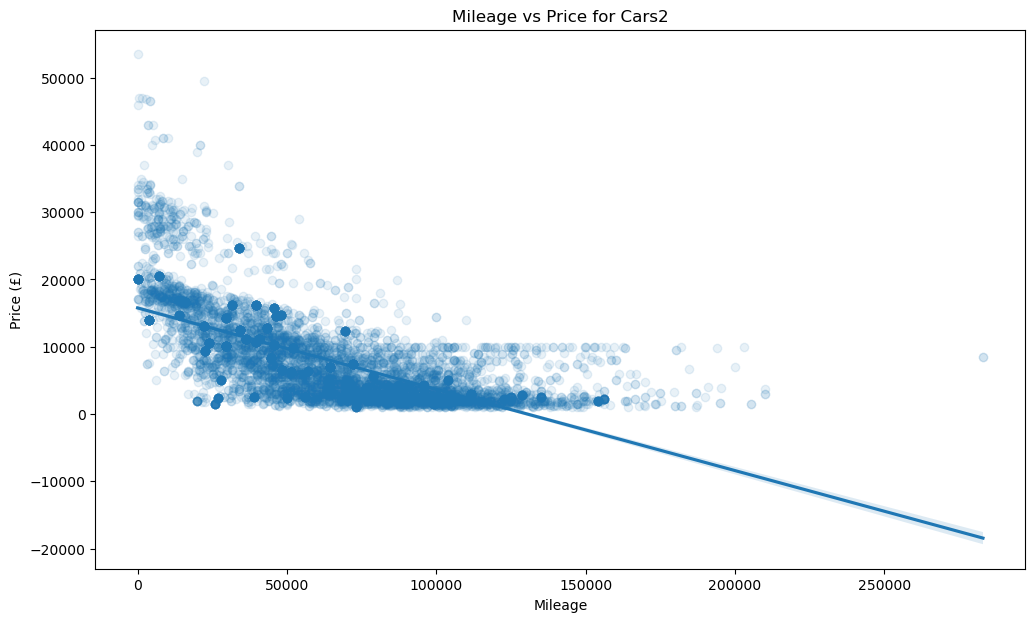

In [105]:

# Plot
plt.figure(figsize=(12,7))
sns.regplot(data=df, x='mileage', y='price',scatter_kws={'alpha':0.1})
plt.xlabel("Mileage")
plt.ylabel("Price (£)")
plt.title("Mileage vs Price for Cars2")
plt.show()
